<a href="https://colab.research.google.com/github/TheSkrill/Image-Denoising-CIFAR/blob/master/Denoising_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [30]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

In [31]:
train_data_clean = (train_data_clean.astype('float32') / 255.)
test_data_clean = test_data_clean.astype('float32') / 255.

img = train_data_clean[15]
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


**THIS IS AN ILLUSTRATION OF APPLYING VARIOUS BASIC FILTERS ON CIFAR-10**
1. Average Filter
2. Gausian Blurring
3. Median Filter
4. Bilateral Filter

(*The details/intricacies of the images were not visible when I displayed all of them together. So, I had to display them serially.*)

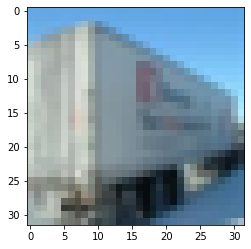

In [32]:
plt.imshow(img)
#plt.title('Original Image')

Text(0.5, 1.0, 'Normal Blurring')

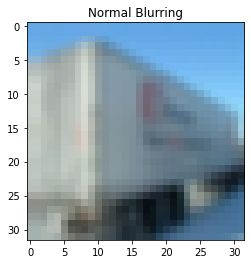

In [33]:
blur = cv2.blur(img,(2,2))
plt.imshow(blur)
plt.title('Normal Blurring')

Text(0.5, 1.0, 'Gausian Blurring')

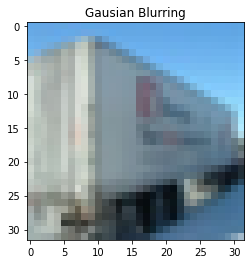

In [34]:
gblur = cv2.GaussianBlur(img, (1, 1),0)
plt.imshow(gblur)
plt.title('Gausian Blurring')

Text(0.5, 1.0, 'Median Blurring')

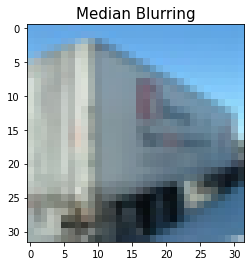

In [35]:
median = cv2.medianBlur(img, 1)
plt.imshow(median)
plt.title('Median Blurring',fontsize=15)

Text(0.5, 1.0, 'Bilateral Filter')

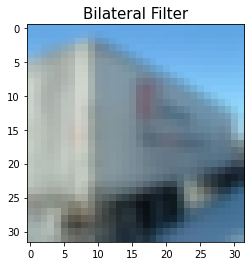

In [36]:
bilateralFilter = cv2.bilateralFilter(img, 2, 250, 250)
plt.imshow(bilateralFilter)
plt.title('Bilateral Filter',fontsize=15)

##**What do we infer from the above pictures?**
1. Average Filter just takes a kernel and averages out the images. Normal Blurring.

2. Gaussian Blurring can be considered efficient, becuase the details/edges of the image weren't lost in the filtering process. SigmaX and SigmaY were kept as zero becuase no change was observed upon varying them as it was a (32x32) image.

3. Median Filtering takes a central value *from the picture itself* and replaces them in the noisy portion. Median blurring brought out the detailing in the image. Many websites considered it to be the most efficient, but in CIFAR-10, I found it similar to Gaussian Blurring in performance.

4. Bilateral Filtering is well-known for conserving the edges and blurring out the rest. Here, I found minimal result on it even after varying the SigmaColor and the SigmaCoordinate values.


> Best one : **Median Filter**






In [37]:
#Adding additional noise to the image
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.) #Normalizing it betn 0 to 1
   return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7d3a4522b0>,
 Text(0.5, 1.0, 'Noisy Image'),
 <matplotlib.image.AxesImage at 0x7f7d3a413b70>)

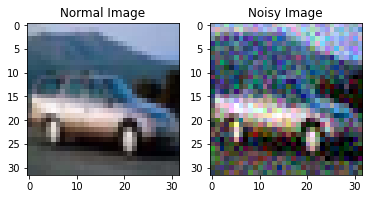

In [38]:
img = train_data_clean[4]
noisy_img = train_data_noisy[4]

plt.subplot(121),plt.title('Normal Image'),plt.imshow(img)
plt.subplot(122),plt.title('Noisy Image'),plt.imshow(noisy_img)

##**IDEA** :


###***Now, instead of applying CNNs in de-noising, what if we just add a Gaussian Filter in the noisy image?***

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7ce1e97a58>,
 Text(0.5, 1.0, 'After Gaussian Filtering'),
 <matplotlib.image.AxesImage at 0x7f7ce1daaf28>)

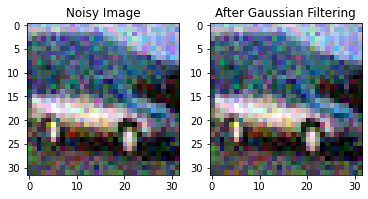

In [61]:
noisy_img = train_data_noisy[4]
gblur = cv2.GaussianBlur(noisy_img, (1, 1),0)

plt.subplot(121),plt.title('Noisy Image'),plt.imshow(noisy_img)
plt.subplot(122),plt.title('After Gaussian Filtering'),plt.imshow(gblur)

###**LOLL, NOOOO!**

Normal filtering doesn't apply when harsh noise is added to CIFAR-10.

*To* eliminate the random noise, I'm trying out an **AutoEncoder**.

In [44]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

In [50]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

model.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 19s 376us/step - loss: 0.0021 - accuracy: 0.7750 - val_loss: 0.0021 - val_accuracy: 0.7772

Epoch 00001: val_loss improved from inf to 0.00206, saving model to best_model.h5
Epoch 2/40
50000/50000 [==============================] - 19s 371us/step - loss: 0.0021 - accuracy: 0.7765 - val_loss: 0.0021 - val_accuracy: 0.7803

Epoch 00002: val_loss did not improve from 0.00206
Epoch 3/40
50000/50000 [==============================] - 19s 370us/step - loss: 0.0020 - accuracy: 0.7783 - val_loss: 0.0018 - val_accuracy: 0.7840

Epoch 00003: val_loss improved from 0.00206 to 0.00184, saving model to best_model.h5
Epoch 4/40
50000/50000 [==============================] - 18s 369us/step - loss: 0.0020 - accuracy: 0.7796 - val_loss: 0.0019 - val_accuracy: 0.7755

Epoch 00004: val_loss did not improve from 0.00184
Epoch 5/40
50000/50000 [==============================] - 18s 369us/step - loss:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7ce20aecf8>,
 Text(0.5, 1.0, 'De-noised Image'),
 <matplotlib.image.AxesImage at 0x7f7ce1f97be0>)

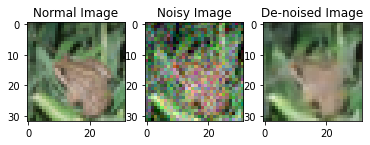

In [54]:
model.load_weights('best_model.h5')
test_data_denoised = model.predict(test_data_noisy)

img = test_data_clean[4]
noisy_img = test_data_noisy[4]
de_noised = test_data_denoised[4]

plt.subplot(131),plt.title('Normal Image'),plt.imshow(img)
plt.subplot(132),plt.title('Noisy Image'),plt.imshow(noisy_img)
plt.subplot(133),plt.title('De-noised Image'),plt.imshow(de_noised)

In [58]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)

noisy_clean_mse, denoised_clean_mse

(0.009306063854376706, 0.0016187032)

In [59]:
print(noisy_clean_mse/denoised_clean_mse)

5.749085808073061


**Hence, the image quality improved ~5.7x times as compared to the noisy image**




NEXT UP, WE ARE GOING TO TRY A NOVEL METHOD : 
###**GENERATIVE ADVERSARIAL NETWORKS**

(*Not executed as it took tremendous amount of time and GAN-training is unstable, just coded the architecture.*)

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

In [ ]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

**INFERENCES**


*   Various Filters were analyzed, but harsh noise renders them ineffective on CIFAR-10 datasets.
*   Auto-encoders proved very effective while dealing with noise.

*   Next up, GANs prove to be more efficacious as compared to Autoencoders! 
(*But due to training time taken and it's unstability, they aren't tested yet.*)



